In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from itertools import combinations
from datetime import datetime
import statsmodels.api as sm
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
from sklearn.metrics import r2_score, mean_squared_error

pd.options.mode.chained_assignment = None
import plotly.express as px
from pycaret.clustering import *

plt.rcParams["axes.facecolor"] = "#A2A2A2"
plt.rcParams["axes.grid"] = 1

# 1) General Infos & Playing with Features

In [61]:
df = pd.read_csv('DataSet/data.csv',encoding= 'unicode_escape')
display(df.head())
print(df.shape)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


(541909, 8)


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [63]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [64]:
df[df.Description.isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,12/7/2011 18:26,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,12/7/2011 18:31,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,12/7/2011 18:35,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,12/8/2011 10:33,0.0,NaN,United Kingdom


In [65]:
df[df.Description.isnull()].CustomerID.nunique()

0

In [66]:
df[df.Description.isnull()].UnitPrice.value_counts()

0.0    1454
Name: UnitPrice, dtype: int64

In [67]:
df = df[df.Description.notnull()]

In [68]:
df[df.CustomerID.isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,12/1/2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom


In [69]:
print("We have {} observations.".format(df.shape[0]))

df = df[df.CustomerID.notnull()]

print("We have {} observations after removing unknown customers.".format(df.shape[0]))

We have 540455 observations.
We have 406829 observations after removing unknown customers.


In [70]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [71]:
df.InvoiceNo.value_counts() 

576339    542
579196    533
580727    529
578270    442
573576    435
         ... 
554155      1
570248      1
545414      1
545418      1
565192      1
Name: InvoiceNo, Length: 22190, dtype: int64

In [72]:
df[df["InvoiceNo"].str.startswith("C")] #C ซึ่งหมายถึงการยกเลิก

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


In [73]:
df["Cancelled"] = df["InvoiceNo"].apply(lambda x: 1 if x.startswith("C") else 0)

In [74]:
cancelled_invoiceNo = df[df.Cancelled == 1].InvoiceNo.tolist()
cancelled_invoiceNo = [x[1:] for x in cancelled_invoiceNo]

cancelled_invoiceNo[:5]

['536379', '536383', '536391', '536391', '536391']

In [75]:
df[df["InvoiceNo"].isin(cancelled_invoiceNo)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled


In [76]:
df[df.InvoiceNo.str.len() != 6]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom,1
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom,1
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom,1
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,1
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,1
...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom,1
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom,1
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom,1
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom,1


In [77]:
df = df[df.Cancelled == 0]

In [78]:
df[df.StockCode.str.contains("^[a-zA-Z]")].StockCode.value_counts()

POST            1099
M                290
C2               133
DOT               16
BANK CHARGES      12
PADS               4
Name: StockCode, dtype: int64

In [79]:
df[df.StockCode.str.contains("^[a-zA-Z]")].Description.value_counts()

POSTAGE                       1099
Manual                         290
CARRIAGE                       133
DOTCOM POSTAGE                  16
Bank Charges                    12
PADS TO MATCH ALL CUSHIONS       4
Name: Description, dtype: int64

In [80]:
df[df.StockCode.str.len() > 5].StockCode.value_counts()

85123A    2035
85099B    1618
82494L     820
85099F     664
85099C     659
          ... 
35610C       1
90187B       1
90190A       1
90190B       1
90214Z       1
Name: StockCode, Length: 875, dtype: int64

In [81]:
df[df.StockCode.str.len() > 5].Description.value_counts()

WHITE HANGING HEART T-LIGHT HOLDER     2028
JUMBO BAG RED RETROSPOT                1618
WOODEN FRAME ANTIQUE WHITE              820
JUMBO BAG STRAWBERRY                    664
JUMBO  BAG BAROQUE BLACK WHITE          659
                                       ... 
PURPLE/BLUE CERAMIC CANDLE HOLDER         1
ORANGE PENDANT TRIPLE SHELL NECKLAC       1
ROSE PENDANT TRIPLE SHELL NECKLACE        1
BLACK CHRISTMAS FLOCK DROPLET             1
CURIOUS IMAGES SCRAP BOOK SET             1
Name: Description, Length: 887, dtype: int64

In [82]:
df =  df[~ df.StockCode.str.contains("^[a-zA-Z]")]

In [83]:
df["Description"] = df["Description"].str.lower()

In [84]:
df.groupby("StockCode")["Description"].nunique()[df.groupby("StockCode")["Description"].nunique() != 1]
#213 Stock codes have more than one description. Let's check some of them.

StockCode
16156L    2
17107D    3
20622     2
20725     2
20914     2
21109     2
21112     2
21175     2
21232     2
21243     2
21507     2
21811     2
21818     2
21899     2
21928     2
22129     2
22134     2
22135     2
22179     2
22197     2
22199     2
22246     2
22268     2
22285     2
22286     2
22287     2
22383     2
22407     2
22416     2
22466     2
22502     2
22584     2
22595     2
22597     2
22602     2
22632     2
22776     3
22777     2
22778     2
22785     2
22804     2
22812     2
22813     2
22837     2
22847     2
22849     2
22896     2
22900     2
22932     2
22937     3
22939     2
22949     2
22950     2
22952     2
22953     2
22963     2
22965     2
22972     2
22985     2
22986     2
22999     2
23015     2
23020     2
23028     2
23029     2
23031     2
23032     2
23035     2
23040     2
23041     2
23043     2
23044     2
23045     2
23047     2
23056     2
23057     2
23061     2
23065     2
23066     2
23068     2
23071     2
23075     2
23079 

In [85]:
df[df.StockCode == "16156L"].Description.value_counts()

wrap carousel     14
wrap, carousel     4
Name: Description, dtype: int64

In [86]:
df[df.StockCode == "17107D"].Description.value_counts()

flower fairy,5 summer b'draw liners    25
flower fairy 5 drawer liners           21
flower fairy 5 summer draw liners       1
Name: Description, dtype: int64

In [87]:
df[df.StockCode == "90014C"].Description.value_counts()

silver/black orbit necklace        2
silver and black orbit necklace    1
Name: Description, dtype: int64

In [88]:
df.CustomerID.value_counts()

17841.0    7838
14911.0    5591
14096.0    5095
12748.0    4580
14606.0    2697
           ... 
14705.0       1
13841.0       1
17715.0       1
18084.0       1
13099.0       1
Name: CustomerID, Length: 4335, dtype: int64

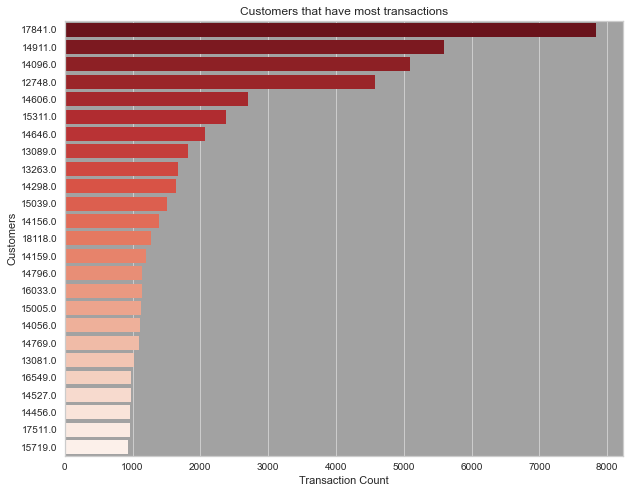

In [89]:
customer_counts = df.CustomerID.value_counts().sort_values(ascending=False).head(25)

fig, ax = plt.subplots(figsize = (10, 8))

sns.barplot(y = customer_counts.index, x = customer_counts.values, orient = "h", 
            ax = ax, order = customer_counts.index, palette = "Reds_r")

plt.title("Customers that have most transactions")
plt.ylabel("Customers")
plt.xlabel("Transaction Count")

plt.show()

In [90]:
df.Country.value_counts()

United Kingdom          354005
Germany                   8659
France                    8034
EIRE                      7138
Spain                     2423
Netherlands               2326
Belgium                   1935
Switzerland               1811
Portugal                  1425
Australia                 1184
Norway                    1049
Channel Islands            744
Italy                      741
Finland                    647
Cyprus                     612
Sweden                     428
Austria                    384
Denmark                    367
Poland                     325
Japan                      321
Israel                     248
Unspecified                244
Singapore                  215
Iceland                    182
USA                        179
Canada                     150
Greece                     142
Malta                      109
United Arab Emirates        67
European Community          57
RSA                         57
Lebanon                     45
Lithuani

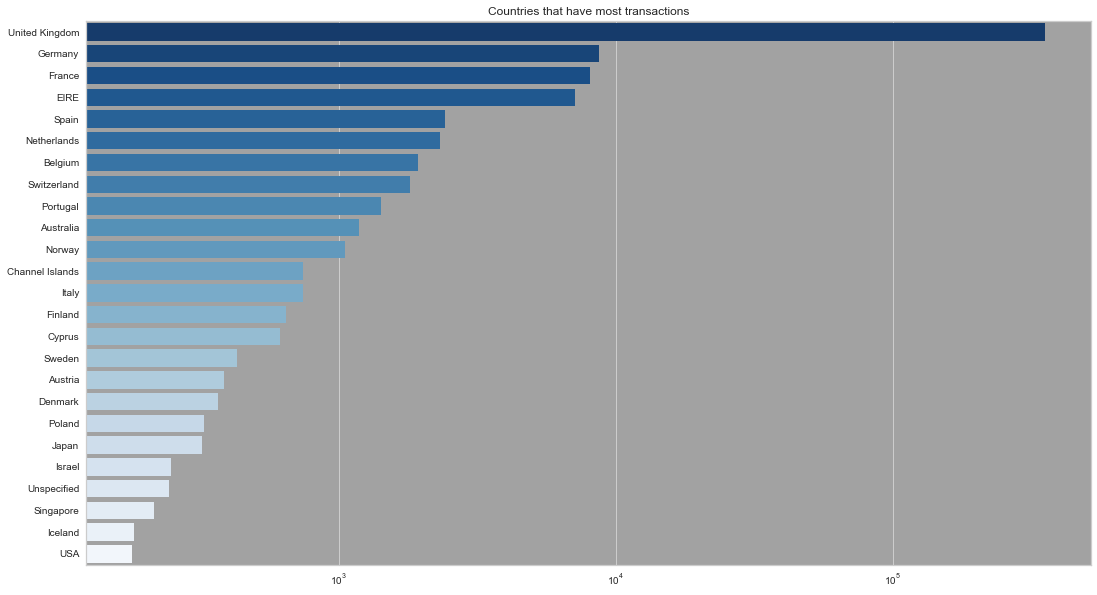

In [91]:
country_counts = df.Country.value_counts().sort_values(ascending=False).head(25)

fig, ax = plt.subplots(figsize = (18, 10))

sns.barplot(x = country_counts.values, y = country_counts.index, orient = "h", 
            ax = ax, order = country_counts.index, palette = "Blues_r")
plt.title("Countries that have most transactions")
plt.xscale("log")
plt.show()

In [92]:
df["UnitPrice"].describe()

count    396370.000000
mean          2.867983
std           4.264566
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [93]:
df[df.UnitPrice == 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
9302,537197,22841,round cake tin vintage green,1,12/5/2010 14:02,0.0,12647.0,Germany,0
33576,539263,22580,advent calendar gingham sack,4,12/16/2010 14:36,0.0,16560.0,United Kingdom,0
40089,539722,22423,regency cakestand 3 tier,10,12/21/2010 13:45,0.0,14911.0,EIRE,0
47068,540372,22090,paper bunting retrospot,24,1/6/2011 16:41,0.0,13081.0,United Kingdom,0
47070,540372,22553,plasters in tin skulls,24,1/6/2011 16:41,0.0,13081.0,United Kingdom,0


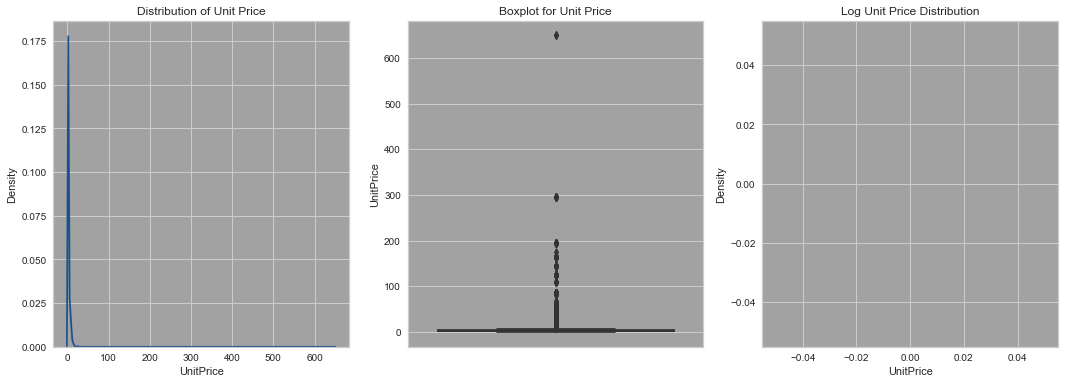

In [94]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["UnitPrice"], ax = axes[0], color = "#195190").set_title("Distribution of Unit Price")
sns.boxplot(y = df["UnitPrice"], ax = axes[1], color = "#195190").set_title("Boxplot for Unit Price")
sns.kdeplot(np.log(df["UnitPrice"]), ax = axes[2], color = "#195190").set_title("Log Unit Price Distribution")

plt.show()

In [95]:
print("Lower limit for UnitPrice: " + str(np.exp(-2)))
print("Upper limit for UnitPrice: " + str(np.exp(3)))

Lower limit for UnitPrice: 0.1353352832366127
Upper limit for UnitPrice: 20.085536923187668


In [96]:
np.quantile(df.UnitPrice, 0.99)

12.75

In [97]:
print("We have {} observations.".format(df.shape[0]))

df = df[(df.UnitPrice > 0.1) & (df.UnitPrice < 20)]

print("We have {} observations after removing unit prices smaller than 0.1 and greater than 20.".format(df.shape[0]))

We have 396370 observations.
We have 395385 observations after removing unit prices smaller than 0.1 and greater than 20.


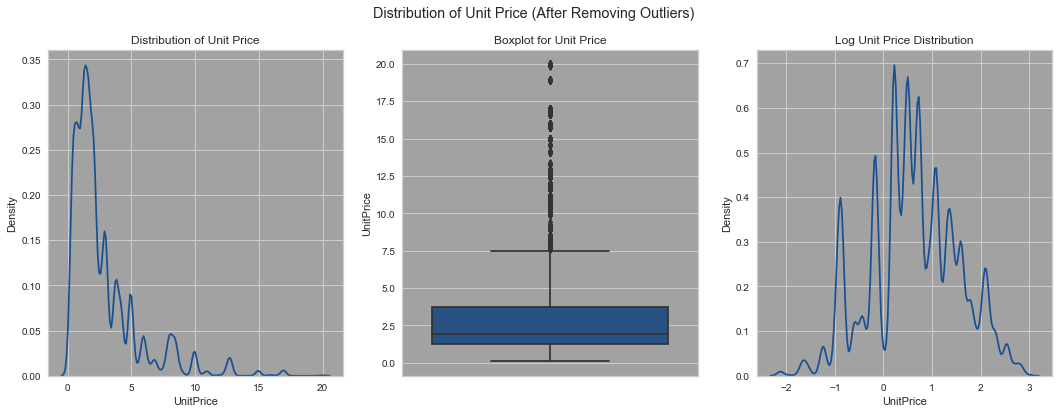

In [98]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["UnitPrice"], ax = axes[0], color = "#195190").set_title("Distribution of Unit Price")
sns.boxplot(y = df["UnitPrice"], ax = axes[1], color = "#195190").set_title("Boxplot for Unit Price")
sns.kdeplot(np.log(df["UnitPrice"]), ax = axes[2], color = "#195190").set_title("Log Unit Price Distribution")

fig.suptitle("Distribution of Unit Price (After Removing Outliers)")
plt.show()

In [99]:
df["Quantity"].describe()

count    395385.000000
mean         12.946075
std         179.665683
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

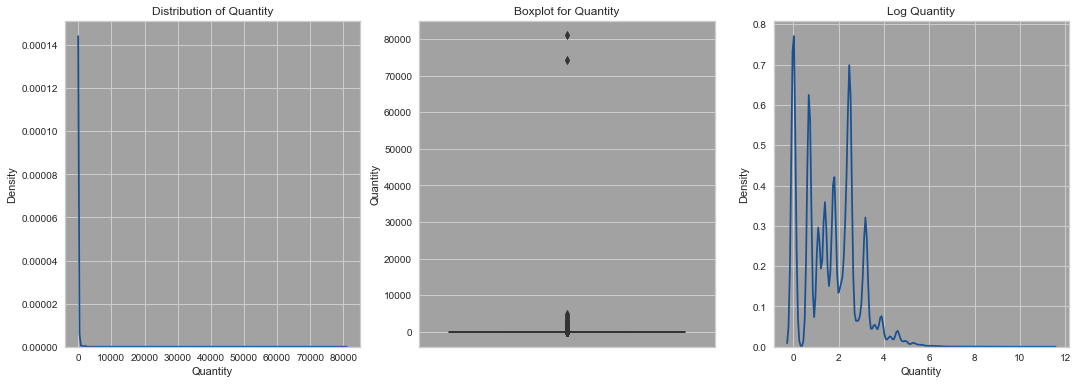

In [100]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["Quantity"], ax = axes[0], color = "#195190").set_title("Distribution of Quantity")
sns.boxplot(y = df["Quantity"], ax = axes[1], color = "#195190").set_title("Boxplot for Quantity")
sns.kdeplot(np.log(df["Quantity"]), ax = axes[2], color = "#195190").set_title("Log Quantity")
plt.show()

In [101]:
print("Upper limit for Quantity: " + str(np.exp(5)))

Upper limit for Quantity: 148.4131591025766


In [102]:
print("We have {} observations.".format(df.shape[0]))

df = df[(df.Quantity < 150)]

print("We have {} observations after removing quantities greater than 150.".format(df.shape[0]))

We have 395385 observations.
We have 392735 observations after removing quantities greater than 150.


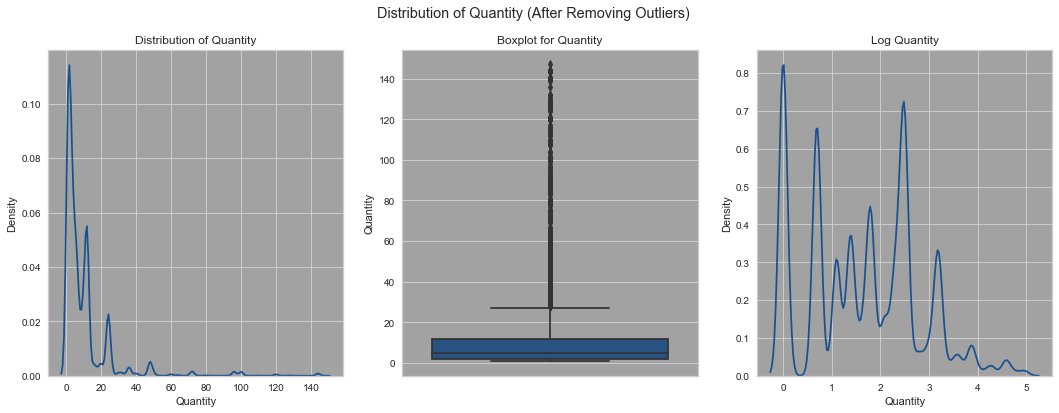

In [103]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["Quantity"], ax = axes[0], color = "#195190").set_title("Distribution of Quantity")
sns.boxplot(y = df["Quantity"], ax = axes[1], color = "#195190").set_title("Boxplot for Quantity")
sns.kdeplot(np.log(df["Quantity"]), ax = axes[2], color = "#195190").set_title("Log Quantity")

fig.suptitle("Distribution of Quantity (After Removing Outliers)")
plt.show()

In [104]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [105]:
df.drop("Cancelled", axis = 1, inplace = True)
df.to_csv("online_retail_final.csv", index = False)

# Cohort Analysis

In [106]:
print("Min date: {} \nMax date: {}".format(df.InvoiceDate.min(), df.InvoiceDate.max()))
print("Time difference is: {}".format(df.InvoiceDate.max() - df.InvoiceDate.min()))

Min date: 2010-12-01 08:26:00 
Max date: 2011-12-09 12:50:00
Time difference is: 373 days 04:24:00


In [107]:
def get_month(x): return dt.datetime(x.year, x.month, 1) 

def get_dates(df, col):
    
    year = df[col].dt.year
    month = df[col].dt.month
    day = df[col].dt.day
    
    return year, month, day

In [108]:
df["InvoiceMonth"] = df["InvoiceDate"].apply(get_month)

df["CohortMonth"] = df.groupby("CustomerID")["InvoiceMonth"].transform("min")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,CohortMonth
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01


In [109]:
invoice_year, invoice_month, invoice_day = get_dates(df, "InvoiceMonth")
cohort_year, cohort_month, cohort_day = get_dates(df, "CohortMonth")

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

df["CohortIndex"] = 12 * year_diff + month_diff + 1


In [110]:
cohort_data = df.groupby(["CohortIndex", "CohortMonth"])["CustomerID"].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index = "CohortMonth", columns = "CohortIndex", values = "CustomerID")

cohort_pivot

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,874.0,319.0,280.0,329.0,317.0,350.0,316.0,303.0,304.0,345.0,327.0,440.0,231.0
2011-01-01,409.0,91.0,112.0,94.0,131.0,119.0,103.0,100.0,123.0,135.0,151.0,48.0,NaN
2011-02-01,375.0,68.0,69.0,103.0,100.0,90.0,94.0,100.0,92.0,115.0,25.0,NaN,NaN
2011-03-01,450.0,66.0,111.0,90.0,101.0,75.0,119.0,104.0,124.0,38.0,NaN,NaN,NaN
2011-04-01,297.0,64.0,61.0,61.0,56.0,68.0,65.0,77.0,22.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-08-01,170.0,32.0,41.0,41.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-01,297.0,70.0,90.0,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-01,356.0,84.0,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### เรามีลูกค้าที่ไม่ซ้ำ 874 ราย โดยมีธุรกรรมครั้งแรกในปีค.ศ 2010-2012 เดือน cohort month คือ 2010-2012 และ cohort index คือ 1 ไปที่เซลล์ทางขวาคือ 319 ค่าเฉลี่ยคือ ลูกค้าที่ไม่ซ้ำ 319 รายยังคงรักษาสถานะลูกค้าไว้ได้ในเดือนหน้า

## 2.1) Retention Rate

In [111]:
cohort_sizes = cohort_pivot.iloc[:, 0]

retention = cohort_pivot.divide(cohort_sizes, axis = 0)
retention.index = retention.index.strftime("%Y-%m")

retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,1.0,0.364989,0.320366,0.376430,0.362700,0.400458,0.361556,0.346682,0.347826,0.394737,0.374142,0.503432,0.264302
2011-01,1.0,0.222494,0.273839,0.229829,0.320293,0.290954,0.251834,0.244499,0.300733,0.330073,0.369193,0.117359,NaN
2011-02,1.0,0.181333,0.184000,0.274667,0.266667,0.240000,0.250667,0.266667,0.245333,0.306667,0.066667,NaN,NaN
2011-03,1.0,0.146667,0.246667,0.200000,0.224444,0.166667,0.264444,0.231111,0.275556,0.084444,NaN,NaN,NaN
2011-04,1.0,0.215488,0.205387,0.205387,0.188552,0.228956,0.218855,0.259259,0.074074,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-08,1.0,0.188235,0.241176,0.241176,0.129412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09,1.0,0.235690,0.303030,0.114478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10,1.0,0.235955,0.115169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


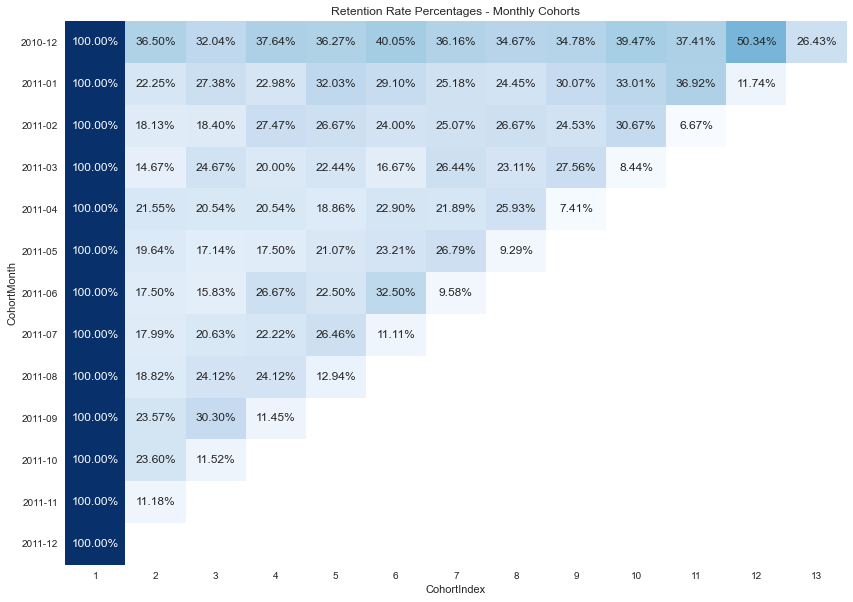

In [112]:
plt.rcParams["axes.facecolor"] = "white"
fig, ax = plt.subplots(figsize = (14, 10))

sns.heatmap(retention, cmap = "Blues", annot = True, fmt = ".2%", annot_kws = {"fontsize": 12}, cbar = False, ax = ax)

plt.title("Retention Rate Percentages - Monthly Cohorts")
plt.yticks(rotation = 0)
plt.show()

40.05% ของลูกค้าที่ซื้อของครั้งแรกในเดือนมกราคม 2011 ใช้บริษัทนี้หลังจากห้าเดือน

In [113]:
customer_per_month = df.groupby("CohortMonth")["CustomerID"].nunique().values
customers = customer_per_month.cumsum()
customers = customers[::-1]
customers

array([4298, 4259, 3937, 3581, 3284, 3114, 2925, 2685, 2405, 2108, 1658,
       1283,  874], dtype=int64)

In [114]:
customer_in_month = df.groupby("CohortIndex")["CustomerID"].nunique()
customer_in_month

CohortIndex
1     4298
2      961
3      930
4      907
5      890
6      866
7      795
8      710
9      665
10     633
11     503
12     488
13     231
Name: CustomerID, dtype: int64

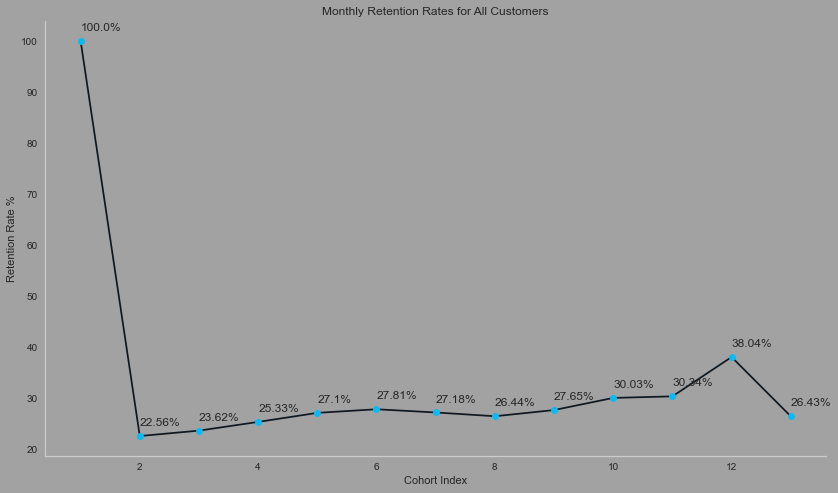

In [115]:
plt.rcParams["axes.facecolor"] = "#A2A2A2"
fig, ax = plt.subplots(figsize = (14, 8), facecolor = "#A2A2A2")
ax.grid(False)
x = customer_in_month.index
y = 100*(customer_in_month / customers)

sns.lineplot(x = x, y = y,  color = "#101820", marker = "o", markerfacecolor = "#0EB8F1", markeredgecolor = "#0000")

for x, y in zip(x, y):
    plt.text(x, y + 2, s = str(round(y, 2)) + "%")

plt.xlabel("Cohort Index")
plt.ylabel("Retention Rate %")
plt.title("Monthly Retention Rates for All Customers")
sns.despine()
plt.show()

#### ยอดเยี่ยม! อัตราการเก็บรักษาเพิ่มขึ้นอย่างมากในช่วงเดือนสุดท้ายของปี อาจเป็นเพราะวันขอบคุณพระเจ้า Black Friday และ Christmas สิ้นปีมีวันพิเศษมากมาย

In [116]:
monthly_customer_price_df = df.groupby("InvoiceMonth").agg({"TotalPrice": "sum",
                                                            "CustomerID": "nunique"})

monthly_customer_price_df

,TotalPrice,CustomerID
InvoiceMonth,,
2010-12-01,477001.27,874
2011-01-01,402460.88,728
2011-02-01,384935.12,746
2011-03-01,501435.63,959
2011-04-01,389147.37,843
...,...,...
2011-08-01,512410.08,920
2011-09-01,775974.69,1246
2011-10-01,841921.28,1351


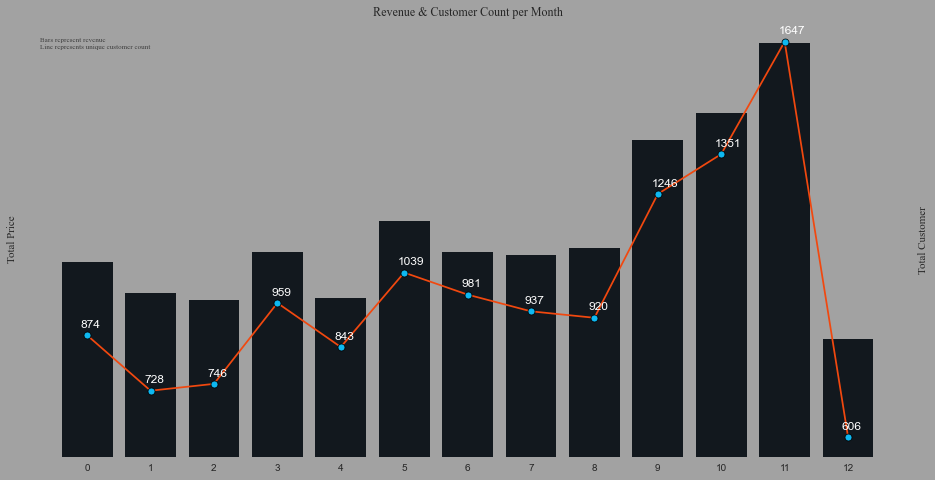

In [117]:
fig, ax = plt.subplots(figsize = (16, 8), facecolor = "#A2A2A2")
ax.set_facecolor("#A2A2A2")

sns.barplot(x = np.arange(len(monthly_customer_price_df.index)), y = monthly_customer_price_df.TotalPrice, ax = ax,
            color = "#101820")
ax2 = ax.twinx()
sns.lineplot(x = np.arange(len(monthly_customer_price_df.index)), y = monthly_customer_price_df.CustomerID, ax = ax2,
            color = "#F1480F", marker = "o", markerfacecolor = "#0EB8F1", markeredgecolor = "#000000")

ax.set_yticks([])
ax2.set_yticks([])
ax2.set_ylabel("Total Customer", fontname = "Times New Roman")
ax.set_ylabel("Total Price", fontname = "Times New Roman")
plt.title("Revenue & Customer Count per Month", fontname = "Times New Roman")
ax.text(-0.75, 1000000, "Bars represent revenue \nLine represents unique customer count", 
        fontsize = 7, alpha = 0.8, fontname = "Times New Roman")
for x, y in zip(np.arange(len(monthly_customer_price_df.index)),  monthly_customer_price_df.CustomerID):
    ax2.text(x -0.1, y + 20 , y, color = "white")
    
sns.despine(left = True, right = True, bottom = True, top = True)
plt.show()

## 3) Pareto Principle

In [118]:
def prepare_pareto_data(df, col, price):
    
    df_price = pd.DataFrame(df.groupby(col)[price].sum())
    df_price = df_price.sort_values(price, ascending = False)

    df_price["CumulativePercentage"] = (df_price[price].cumsum() / df_price[price].sum() * 100).round(2)
    
    return df_price

In [119]:
def create_pareto_plot(df, col, price, log = True):
    
    plt.rcParams["axes.facecolor"] = "#A2A2A2"
    fig, ax = plt.subplots(figsize = (15, 5), dpi = 150, facecolor = "#A2A2A2")
    plt.rcParams["axes.grid"] = False
    
    if log == True:
        sns.barplot(x = np.arange(len(df)), y = np.log(df[price]),  ax = ax, color = "#101820")
        ax.set_ylabel("Total Price (Log - Scale)")
    else:
        sns.barplot(x = np.arange(len(df)), y = df[price],  ax = ax, color = "#101820")

    ax2 = ax.twinx()
    
    sns.lineplot(x = np.arange(len(df)), y = df.CumulativePercentage, ax = ax2, color = "#0019AA")
    ax2.axhline(80, color = "#008878", linestyle = "dashed", alpha = 1)
    ax2.axhline(90, color = "#008878", linestyle = "dashed", alpha = 0.75)

    vlines = [int(len(df) * x / 10) for x in range(1, 10)]
    for vline in vlines: ax2.axvline(vline, color = "#008878", linestyle = "dashed", alpha = 0.1)
        
    interaction_80 = (df.shape[0] - df[df.CumulativePercentage >= 80].shape[0])
    ax2.axvline(interaction_80, color = "#008878", linestyle = "dashed", alpha = 1)

    interaction_80_percentage = round((interaction_80 / df.shape[0]) * 100)
    plt.text(interaction_80 + 25, 95, str(interaction_80_percentage) + "%")   
    
    prop = dict(arrowstyle= "-|>", color = "#000000", lw = 1.5, ls = "--")
    plt.annotate("", xy = (interaction_80 - 10, 80),  xytext = (interaction_80 + 120 , 73), arrowprops = prop)
    
    interaction_90 = (df.shape[0] - df[df.CumulativePercentage >= 90].shape[0])
    ax2.axvline(interaction_90, color = "#008878", linestyle = "dashed", alpha = 0.8)
    interaction_90_percentage = round((interaction_90 / df.shape[0]) * 100)
    plt.text(interaction_90 + 25, 95, str(interaction_90_percentage) + "%")   
    plt.annotate("", xy = (interaction_90 - 10, 90),  xytext = (interaction_90 + 120 , 83), arrowprops = prop)

    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax.set_yticks([])
    plt.xticks([])
    ax.set_ylabel("Revenue", fontname = "Times New Roman")
    ax2.set_ylabel("Cumulative Percentage", fontname = "Times New Roman")
    subject = "Customers" if col == "CustomerID" else "Products"
    plt.title("Pareto Chart for " + subject, fontname = "Times New Roman")
    ax.set_xlabel(subject, fontname = "Times New Roman")
    sns.despine(left = True, right = True, bottom = True, top = True)
    plt.show()

### 3.1) Pareto Chart for Customers

In [120]:
customer_price = prepare_pareto_data(df, "CustomerID", "TotalPrice")

customer_price.head(10)

,TotalPrice,CumulativePercentage
CustomerID,,
14646.0,189796.00,2.65
14911.0,129795.43,4.46
12415.0,81455.09,5.60
14156.0,81329.92,6.73
18102.0,80619.70,7.86
17511.0,78595.72,8.95
15311.0,57178.46,9.75
13089.0,56618.82,10.54
14096.0,52147.65,11.27


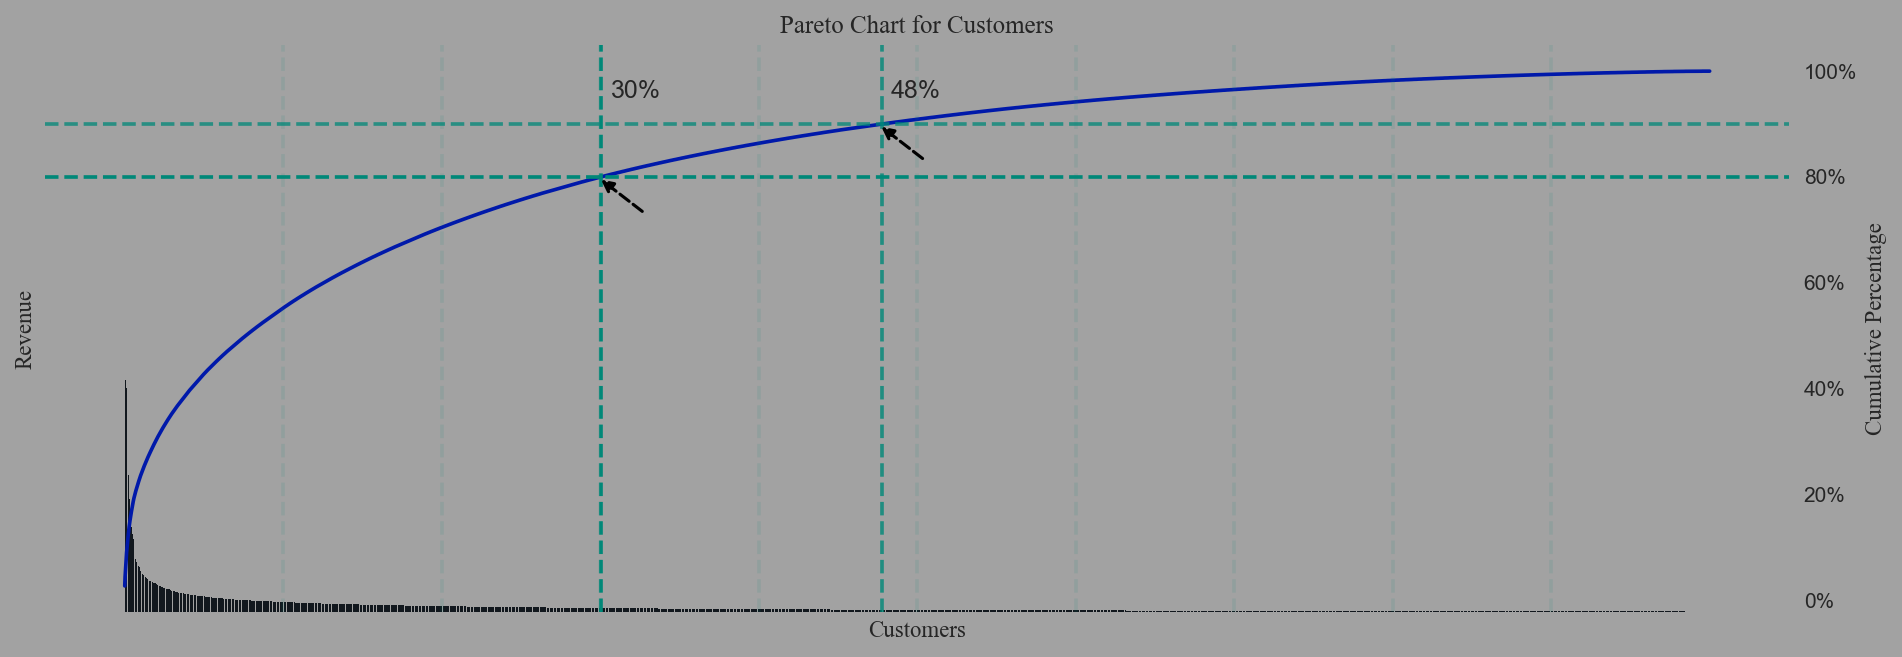

In [121]:
create_pareto_plot(customer_price, "CustomerID", "TotalPrice", log = False)

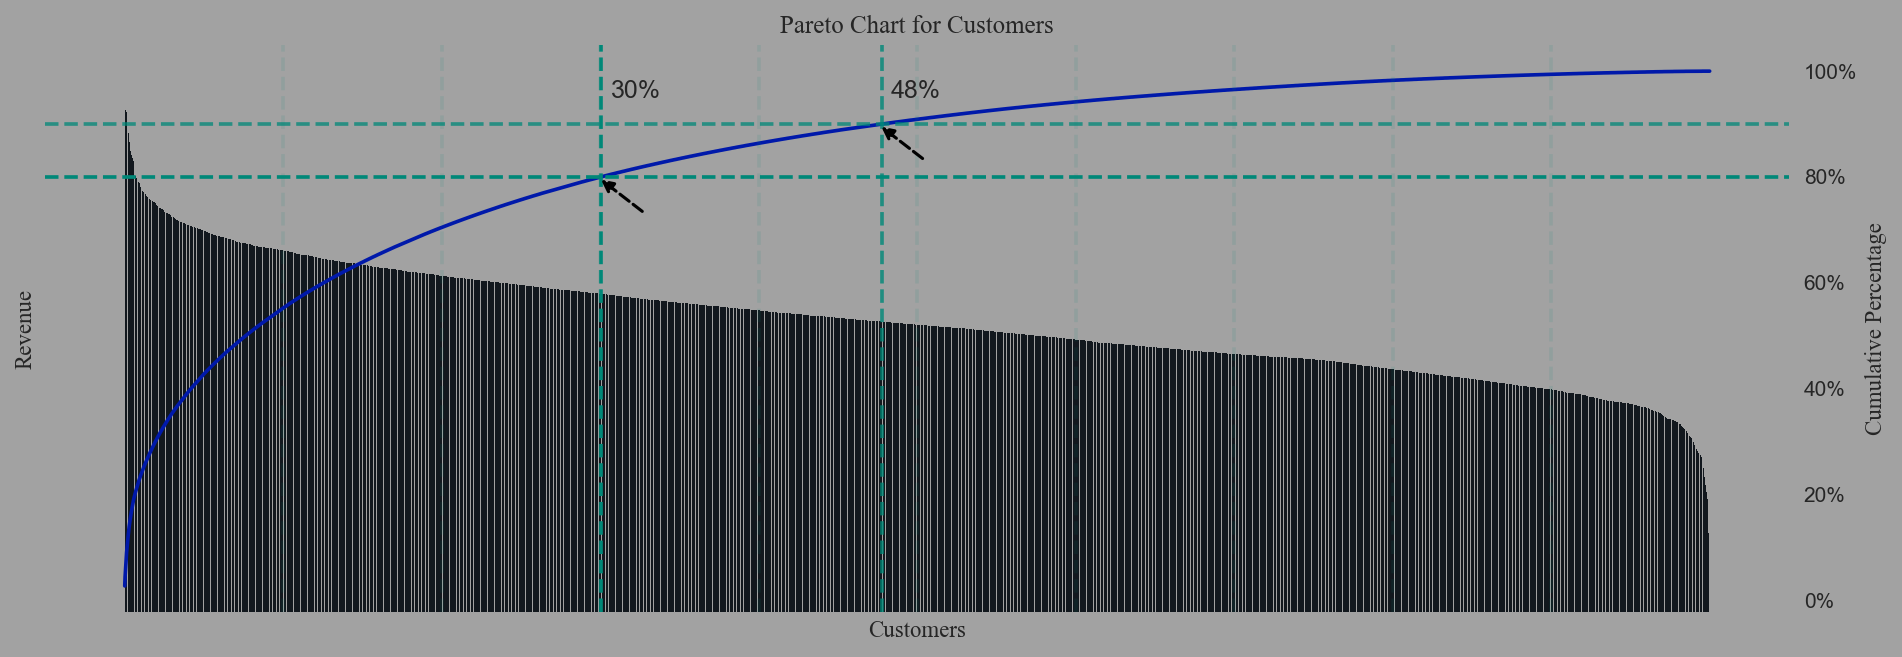

In [122]:
create_pareto_plot(customer_price, "CustomerID", "TotalPrice", log = True)

**จากรูปจะเห็นได้่ว่า** รายได้ของบริษัท 80% มาจากลูกค้า 30% อันดับต้นๆ นอกจากนี้ 90% ของรายได้ของบริษัทยังมาจากลูกค้า 48% อันดับต้นๆ

### 3.2) Pareto Chart for Products

In [123]:
item_price = prepare_pareto_data(df, "StockCode", "TotalPrice")

item_price.head(10)

,TotalPrice,CumulativePercentage
StockCode,,
22423,132100.75,1.84
85123A,68282.78,2.80
47566,61166.83,3.65
85099B,57382.08,4.45
79321,37464.27,4.97
84879,37428.74,5.50
22086,35337.23,5.99
23298,31210.55,6.42
22960,30038.77,6.84


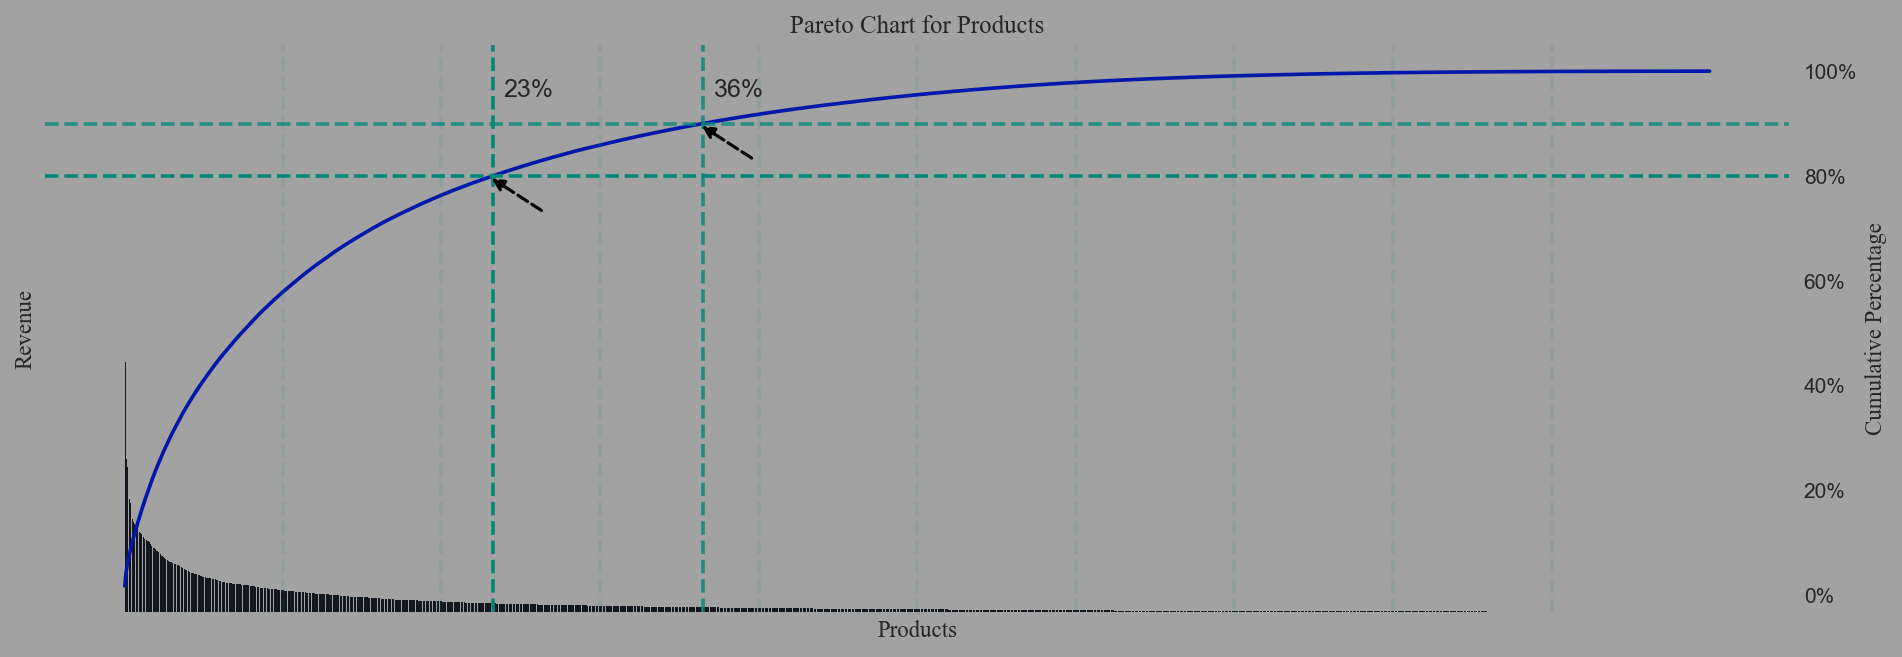

In [124]:
create_pareto_plot(item_price, "StockCode", "TotalPrice", log = False)

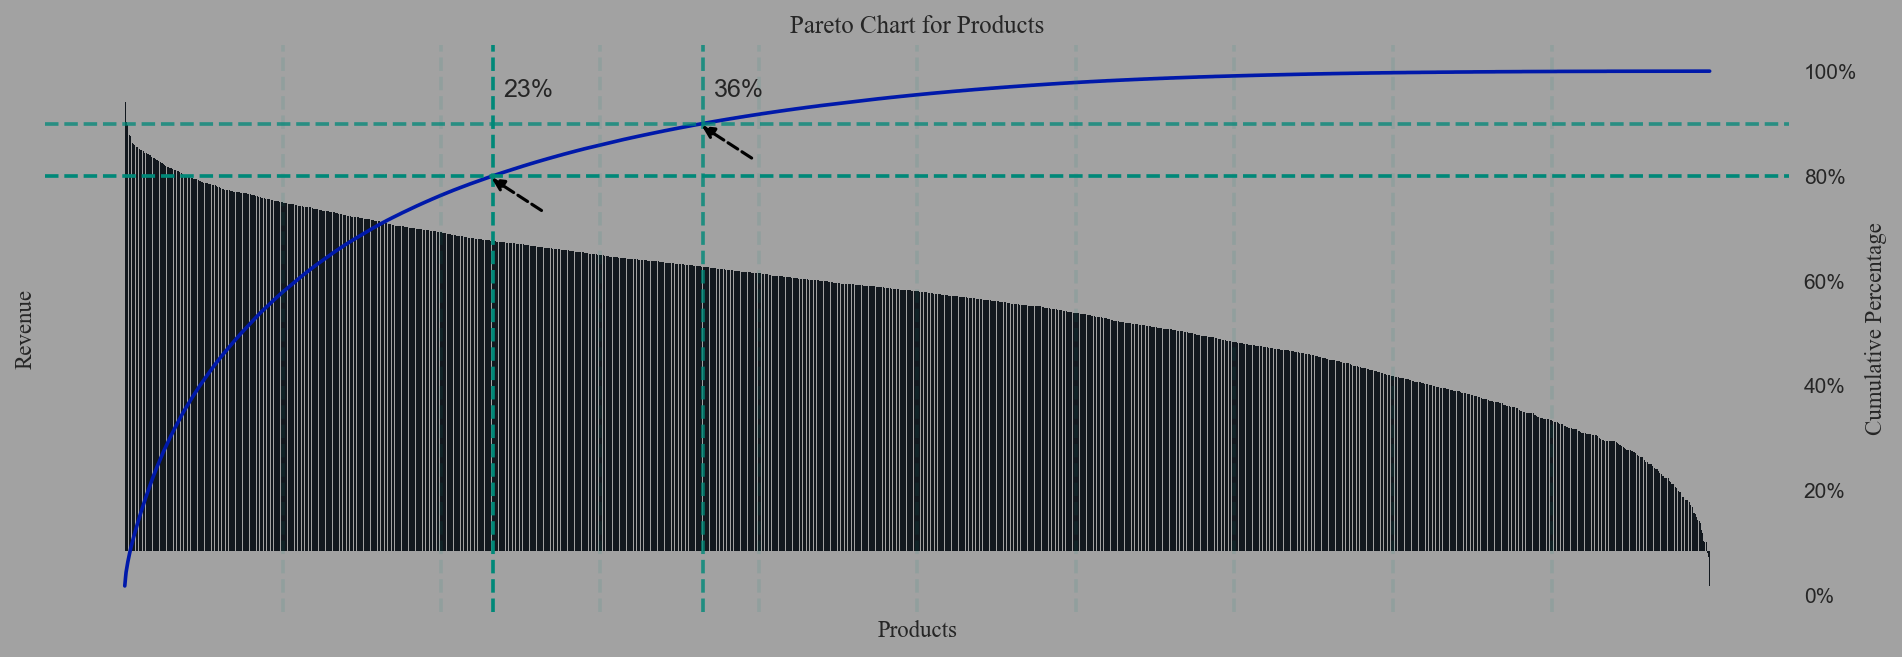

In [125]:
create_pareto_plot(item_price, "StockCode", "TotalPrice")

**จากรูปจะเห็นได้่ว่า**รายได้ของบริษัท 80% มาจาก 23% อันดับแรกของผลิตภัณฑ์ที่มีรายได้มากที่สุด นอกจากนี้ 90% ของรายได้ของบริษัทมาจาก 36% ของผลิตภัณฑ์ที่มีรายได้มากที่สุด บางทีหากบริษัทลดจำนวนสินค้าลงครึ่งหนึ่งรายได้ก็อาจไม่ลดลงมากนัก

In [126]:
top_customers = customer_price[customer_price.CumulativePercentage <= 80].index.tolist()

products_for_top_customers = df[df.CustomerID.isin(top_customers)].Description.drop_duplicates().values.tolist()

products_for_other_customers = df[~df.CustomerID.isin(top_customers)].Description.drop_duplicates().values.tolist()

# RFM Analysis

In [127]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [128]:
df_uk = df.query("Country == 'United Kingdom' ").reset_index(drop = True)
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,1
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01,1
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1


In [129]:
# สร้างดาต้าเฟรมผู้ใช้ทั่วไปเพื่อเก็บ CustomerID และคะแนนการแบ่งกลุ่มใหม่
df_user = pd.DataFrame(df['CustomerID'].unique())
df_user.columns = ['CustomerID']

# วันที่ซื้อสูงสุดสำหรับลูกค้าแต่ละรายและสร้างดาต้าเฟรมด้วย
df_max_purchase = df_uk.groupby('CustomerID').InvoiceDate.max().reset_index()
df_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

# เราใช้จุดสังเกตของเราเป็นวันที่ใบแจ้งหนี้สูงสุดในชุดข้อมูลของเรา
# (Recency) คือ ระยะเวลาที่ลูกค้ามาใช้บริการครั้งสุดท้าย ล่าสุดเมื่อไหร่
df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days

# รวมดาต้าเฟรมนี้เข้ากับดาต้าเฟรมผู้ใช้ใหม่ของเรา
df_user = pd.merge(df_user, df_max_purchase[['CustomerID','Recency']] , on='CustomerID')

df_user.head()

,CustomerID,Recency
0,17850.0,371
1,13047.0,56
2,13748.0,95
3,15100.0,333
4,15291.0,25


In [130]:
exp_name = setup(data = df_user,  normalize = True,ignore_features = ['CustomerID']  )
kmeans = create_model('kmeans')
df_user = assign_model(kmeans)

df_user.Cluster.replace('Cluster 0' , 0 , inplace=True)
df_user.Cluster.replace('Cluster 1' , 1 , inplace=True)
df_user.Cluster.replace('Cluster 2' , 2 , inplace=True)
df_user.Cluster.replace('Cluster 3' , 3 , inplace=True)

df_user.columns = ['CustomerID', 'Recency', 'RecencyCluster']
df_user = order_cluster('RecencyCluster', 'Recency',df_user,False)
df_user.head()

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6187,21663.203,0.5153,0,0,0


create_model_container: 1
master_model_container: 1
display_container: 2
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=8276, tol=0.0001, verbose=0)
create_model() succesfully completed......................................
Initializing assign_model()
assign_model(model=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=8276, tol=0.0001, verbose=0), transformation=False, score=True, verbose=True)
Checking exceptions
Determining Trained Model
Trained Model : K-Means Clustering
Copying data
(3882, 3)
assign_model() succesfully completed......................................


,CustomerID,Recency,RecencyCluster
0,17850.0,371,0
1,15100.0,333,0
2,18074.0,373,0
3,16250.0,260,0
4,13747.0,373,0


In [131]:
df_user.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,371,0
1,15100.0,333,0
2,18074.0,373,0
3,16250.0,260,0
4,13747.0,373,0


In [132]:
# จำนวนการสั่งซื้อสำหรับผู้ใช้แต่ละคนและสร้างดาต้าเฟรม
df_frequency = df_uk.groupby('CustomerID').InvoiceDate.count().reset_index()
df_frequency.columns = ['CustomerID','Frequency']

# เพิ่มข้อมูลนี้ในดาต้าเฟรมหลัก
df_user = pd.merge(df_user, df_frequency, on='CustomerID')

exp_name = setup(data = df_user.drop(columns=['Recency' , 'RecencyCluster' ]),  normalize = True,ignore_features = ['CustomerID']    )


kmeans = create_model('kmeans')
kmeans_df = assign_model(kmeans)

kmeans_df.Cluster.replace('Cluster 0' , 0 , inplace=True)
kmeans_df.Cluster.replace('Cluster 1' , 1 , inplace=True)
kmeans_df.Cluster.replace('Cluster 2' , 2 , inplace=True)
kmeans_df.Cluster.replace('Cluster 3' , 3 , inplace=True)

df_user['FrequencyCluster'] = kmeans_df['Cluster']
df_user = order_cluster('FrequencyCluster', 'Frequency',df_user,True)
df_user.groupby('FrequencyCluster')['Frequency'].describe()


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7585,7969.8687,0.4811,0,0,0


create_model_container: 1
master_model_container: 1
display_container: 2
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=1168, tol=0.0001, verbose=0)
create_model() succesfully completed......................................
Initializing assign_model()
assign_model(model=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=1168, tol=0.0001, verbose=0), transformation=False, score=True, verbose=True)
Checking exceptions
Determining Trained Model
Trained Model : K-Means Clustering
Copying data
(3882, 3)
assign_model() succesfully completed......................................


,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3408.0,48.067195,42.789673,1.0,15.0,33.0,71.0,177.0
1,438.0,305.552511,116.990722,178.0,213.0,270.0,362.5,694.0
2,33.0,1094.363636,475.139112,701.0,751.0,967.0,1140.0,2692.0
3,3.0,5812.333333,1755.215181,4557.0,4809.5,5062.0,6440.0,7818.0


In [133]:
df_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,17850.0,371,0,289,1
1,15808.0,305,0,208,1
2,14307.0,88,2,180,1
3,16928.0,79,2,208,1
4,15301.0,50,2,242,1


In [134]:
df_revenue = df_uk.groupby('CustomerID').TotalPrice.sum().reset_index()

# รวมข้อมูลหลัก 
df_user = pd.merge(df_user, df_revenue, on='CustomerID')

exp_name = setup(data = df_user.drop(columns=['Recency' , 'RecencyCluster' , 'Frequency' , 'FrequencyCluster' ]),  normalize = True ,ignore_features = ['CustomerID']   )
kmeans = create_model('kmeans')
kmeans_df = assign_model(kmeans)

kmeans_df.Cluster.replace('Cluster 0' , 0 , inplace=True)
kmeans_df.Cluster.replace('Cluster 1' , 1 , inplace=True)
kmeans_df.Cluster.replace('Cluster 2' , 2 , inplace=True)
kmeans_df.Cluster.replace('Cluster 3' , 3 , inplace=True)

df_user['TotalPriceCluster'] = kmeans_df['Cluster']

df_user = order_cluster('TotalPriceCluster', 'TotalPrice',df_user,True)
df_user.head()

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.7773,9042.584,0.505,0,0,0


create_model_container: 1
master_model_container: 1
display_container: 2
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=8724, tol=0.0001, verbose=0)
create_model() succesfully completed......................................
Initializing assign_model()
assign_model(model=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=8724, tol=0.0001, verbose=0), transformation=False, score=True, verbose=True)
Checking exceptions
Determining Trained Model
Trained Model : K-Means Clustering
Copying data
(3882, 3)
assign_model() succesfully completed......................................


,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,TotalPrice,TotalPriceCluster
0,17850.0,371,0,289,1,4783.46,1
1,15808.0,305,0,208,1,3734.97,1
2,15301.0,50,2,242,1,4447.85,1
3,13842.0,58,2,205,1,3363.67,1
4,16556.0,66,2,207,1,3313.79,1


In [135]:
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,1
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01,1
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1


In [136]:
df_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,TotalPrice,TotalPriceCluster
0,17850.0,371,0,289,1,4783.46,1
1,15808.0,305,0,208,1,3734.97,1
2,15301.0,50,2,242,1,4447.85,1
3,13842.0,58,2,205,1,3363.67,1
4,16556.0,66,2,207,1,3313.79,1


In [137]:
df_user['OverallScore'] = df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['TotalPriceCluster']
df_user.groupby('OverallScore')['Recency','Frequency','TotalPrice'].mean()

df_user['Segment'] = 'Low-Value'
df_user.loc[df_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
df_user.loc[df_user['OverallScore']>5,'Segment'] = 'High-Value' 
df_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,TotalPrice,TotalPriceCluster,OverallScore,Segment
0,17850.0,371,0,289,1,4783.46,1,2,Low-Value
1,15808.0,305,0,208,1,3734.97,1,2,Low-Value
2,15301.0,50,2,242,1,4447.85,1,4,Mid-Value
3,13842.0,58,2,205,1,3363.67,1,4,Mid-Value
4,16556.0,66,2,207,1,3313.79,1,4,Mid-Value


In [138]:
df_user.groupby('OverallScore')['Recency','Frequency','TotalPrice'].mean()

,Recency,Frequency,TotalPrice
OverallScore,,,
0,302.944086,22.556989,314.612581
1,185.765880,31.223230,505.639111
2,79.777035,44.984392,762.270346
3,22.191848,64.805341,1009.254779
4,18.601449,218.782609,3164.325833
5,11.293839,329.535545,5841.257867
6,7.209302,710.395349,13197.552791
7,4.888889,706.555556,35760.437778
8,2.200000,2246.400000,54347.456000


In [139]:
df_graph = df_user.query("TotalPrice < 50000 and Frequency < 2000")
df_graph.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,TotalPrice,TotalPriceCluster,OverallScore,Segment
0,17850.0,371,0,289,1,4783.46,1,2,Low-Value
1,15808.0,305,0,208,1,3734.97,1,2,Low-Value
2,15301.0,50,2,242,1,4447.85,1,4,Mid-Value
3,13842.0,58,2,205,1,3363.67,1,4,Mid-Value
4,16556.0,66,2,207,1,3313.79,1,4,Mid-Value


In [140]:
b = df_user
b = b[['CustomerID' , 'Segment']]
a = df_uk.merge(b, how='left', on='CustomerID')
a.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,CohortMonth,CohortIndex,Segment
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,1,Low-Value
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1,Low-Value
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01,1,Low-Value
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1,Low-Value
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1,Low-Value


In [141]:
#a.to_csv(r'Data_Segment.csv')

In [142]:
rfm_monetary_size = df_user.groupby("Segment").agg({"TotalPrice": "mean",
                                                       "CustomerID": "nunique"})

rfm_monetary_size.rename(columns = {"TotalPrice": "MeanTotalPrice", "CustomerID": "CustomerCount"}, inplace = True)
rfm_monetary_size = rfm_monetary_size.sort_values("MeanTotalPrice", ascending = False)

In [143]:
fig = px.scatter_3d(df_graph, x='TotalPrice', y='Frequency', z='Recency',
              color='Segment')
fig.show()

In [144]:
fig = px.scatter(df_graph,x='Recency',y='Frequency', color="Segment",
                 size='TotalPrice', hover_data=['TotalPrice'])
fig.show()

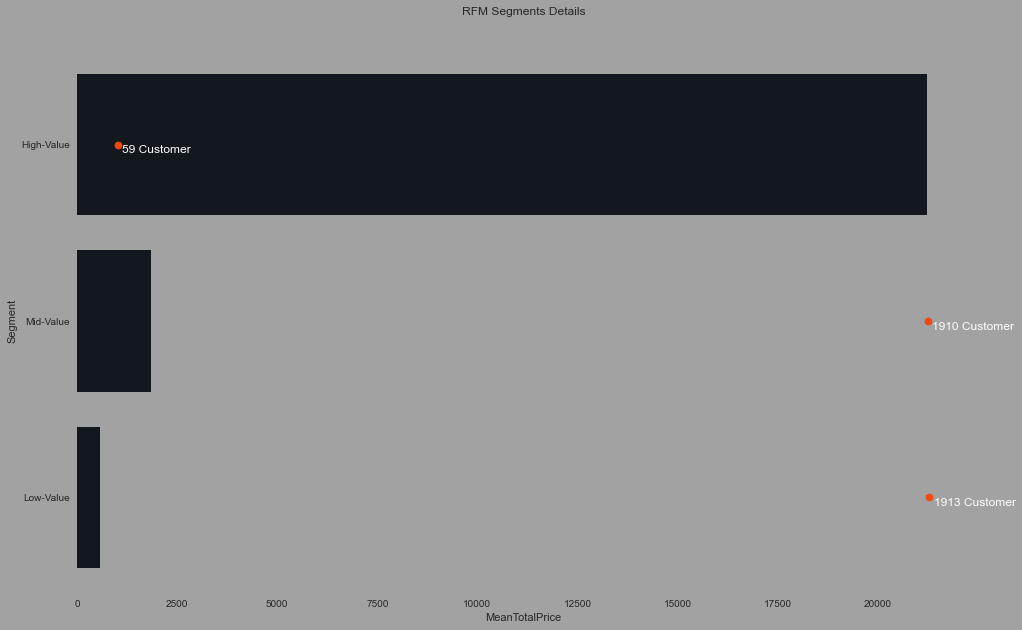

In [145]:
plt.rcParams["axes.facecolor"] = "#A2A2A2"
fig, ax = plt.subplots(figsize = (16, 10), facecolor = "#A2A2A2")

sns.barplot(x = rfm_monetary_size.MeanTotalPrice, y = rfm_monetary_size.index, ax = ax, color = "#101820")
ax2 = ax.twiny()
sns.lineplot(x = rfm_monetary_size.CustomerCount, y = rfm_monetary_size.index, ax = ax2, marker = "o", linewidth = 0,
             color = "#F1480F", markeredgecolor = "#F1480F")


ax2.axis("off")

for y, x in list(enumerate(rfm_monetary_size.CustomerCount)):
    ax2.text(x + 10, y + 0.05, str(x) + " Customer", color = "white", fontweight = "normal")

plt.title("RFM Segments Details")
sns.despine(left = True, right = True, bottom = True, top = True)
plt.show()

In [146]:
rfm = df_user.groupby("Segment").agg({"CustomerID": "nunique", 
                                        "Recency": "mean",
                                        "Frequency": "mean",
                                        "TotalPrice": "mean"})
rfm.rename(columns = {"CustomerID": "Segment Size"}, inplace = True)

cm = sns.light_palette("#A2A2A2", as_cmap = True)

rfm.T.style.background_gradient(cmap = cm, axis = 1)\
.set_precision(2)\
.highlight_min(axis = 1, color = "#195190")\
.highlight_max(axis = 1, color = "#D60000")

Segment,High-Value,Low-Value,Mid-Value
Segment Size,59.00,1913.00,1910.00
Recency,6.25,164.55,20.47
Frequency,1034.20,35.57,116.30
TotalPrice,21234.51,579.54,1854.47


In [147]:
monetary_per_segment = (df_user.groupby("Segment")["TotalPrice"].sum() /\
                        df_user.groupby("Segment")["TotalPrice"].sum().sum()).sort_values(ascending = False)

monetary_per_segment

Segment
Mid-Value     0.599986
High-Value    0.212218
Low-Value     0.187796
Name: TotalPrice, dtype: float64

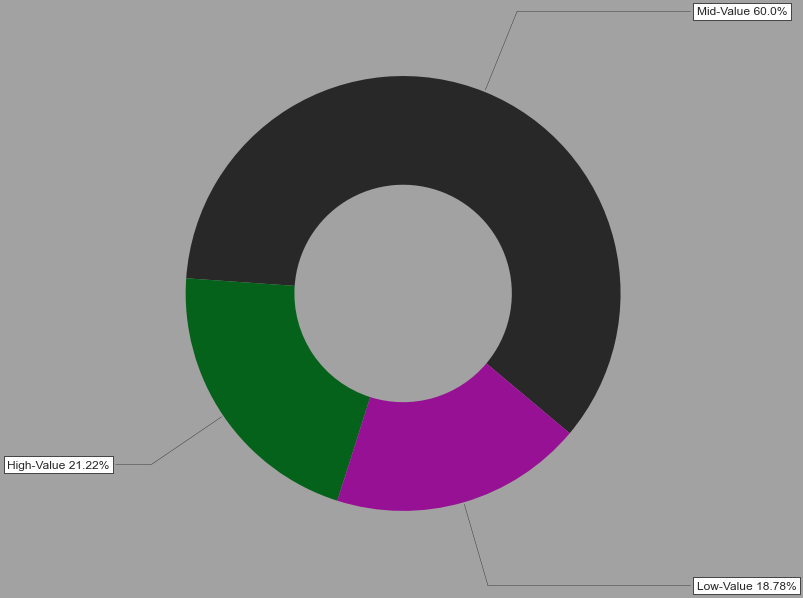

In [148]:
fig, ax = plt.subplots(figsize = (10, 10), facecolor = "#A2A2A2")
palette = ["#282828", "#04621B", "#971194"]

wedges, texts = ax.pie(monetary_per_segment.values, wedgeprops=dict(width=0.5), 
                       startangle=-40, normalize=False, colors = palette)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(monetary_per_segment.index[i] + " " + str(round(monetary_per_segment[i] * 100, 2)) + "%", xy=(x, y), 
                xytext=(1.35*np.sign(x), 1.4*y),horizontalalignment=horizontalalignment, **kw)
plt.show()

รายได้ทั้งหมดมาจากกลุ่ม"กลุ่มลูกค้าระดับสูง"คิดเป็น 20.31%  รายได้ทั้งหมดมาจากกลุ่ม"กลุ่มลูกค้าระดับกลาง"คิดเป็น 60.83% เเละทั้งสองกลุ่มนี้คิดเป็น 81.14% ของรายได้ทั้งหมดของบริษัท

In [149]:
df_user.set_index('CustomerID')

,Recency,RecencyCluster,Frequency,FrequencyCluster,TotalPrice,TotalPriceCluster,OverallScore,Segment
CustomerID,,,,,,,,
17850.0,371,0,289,1,4783.46,1,2,Low-Value
15808.0,305,0,208,1,3734.97,1,2,Low-Value
15301.0,50,2,242,1,4447.85,1,4,Mid-Value
13842.0,58,2,205,1,3363.67,1,4,Mid-Value
16556.0,66,2,207,1,3313.79,1,4,Mid-Value
...,...,...,...,...,...,...,...,...
17511.0,2,3,902,2,78595.72,3,8,High-Value
13089.0,2,3,1808,2,56618.82,3,8,High-Value
14298.0,7,3,1604,2,48263.31,3,8,High-Value


In [150]:
rfm_clustering = df_user[["Recency", "Frequency", "TotalPrice", "Segment"]]

scaler = StandardScaler()
rfm_clustering[["Recency", "Frequency", "TotalPrice"]] = scaler.fit_transform(rfm_clustering[["Recency", "Frequency", "TotalPrice"]])


rfm_melted = pd.melt(rfm_clustering, id_vars = "Segment", value_vars = ["Recency", "Frequency", "TotalPrice"],
                     var_name = "RFM", value_name = "Value")
rfm_melted

,Segment,RFM,Value
0,Low-Value,Recency,2.810146
1,Low-Value,Recency,2.147151
2,Mid-Value,Recency,-0.414420
3,Mid-Value,Recency,-0.334057
4,Mid-Value,Recency,-0.253694
...,...,...,...
11641,High-Value,TotalPrice,20.550462
11642,High-Value,TotalPrice,14.690772
11643,High-Value,TotalPrice,12.462947
11644,High-Value,TotalPrice,10.156431


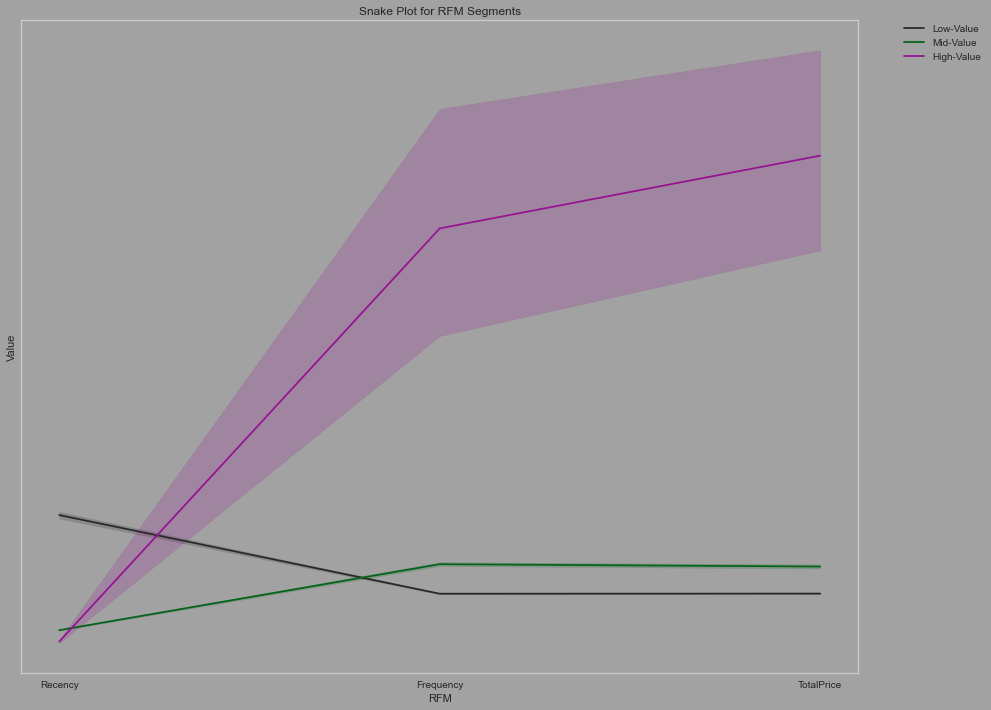

In [151]:
fig, ax = plt.subplots(figsize = (15, 12), facecolor = "#A2A2A2")
ax.set_facecolor("#A2A2A2")

sns.lineplot(x = "RFM", y = "Value", hue = "Segment", data = rfm_melted, palette = palette)
ax.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
ax.set_yticks([])
ax.set_title("Snake Plot for RFM Segments")
plt.show()